In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import boutdata

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

In [3]:


toload = [ 
    dict(name="base", id="xph11a-6ce_grid_noseam_coarseinner", unnormalise_geom = True, use_xhermes = True, squash = False), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case xph11a-6ce_grid_noseam_coarseinner
-----------------------


/ssd_scratch/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/ssd_scratch/scripts/xBOUT/xbout/load.py:1079: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


In [4]:
%matplotlib widget

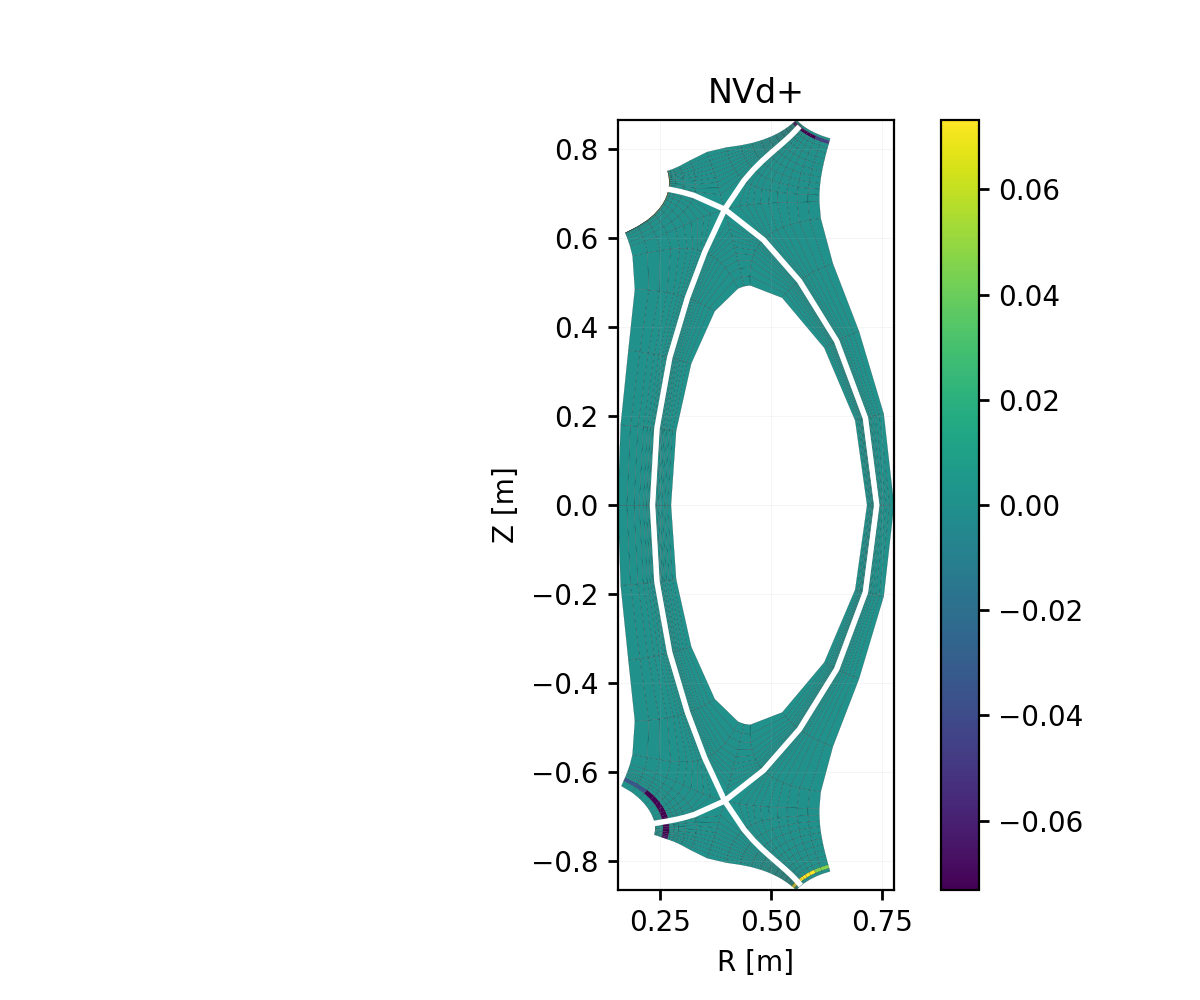

In [20]:
plt.close("all")

fig, ax = plt.subplots(dpi = 200)

ds = cs["base"].ds

ds["NVd+"].bout.polygon(ax = ax, antialias = True, linewidth = 0.05)

In [16]:
np.unique(ds["Td+"].values)

array([500.00000437, 500.00000437, 500.00000437, 500.00000437,
       500.00000437, 500.00000437, 500.00000437, 500.00000437,
       500.00000437, 500.00000437, 500.00000437])

In [4]:
ds = calculate_radial_fluxes(ds)
ds = calculate_target_fluxes(ds)

NameError: name 'ds' is not defined

# State of Td

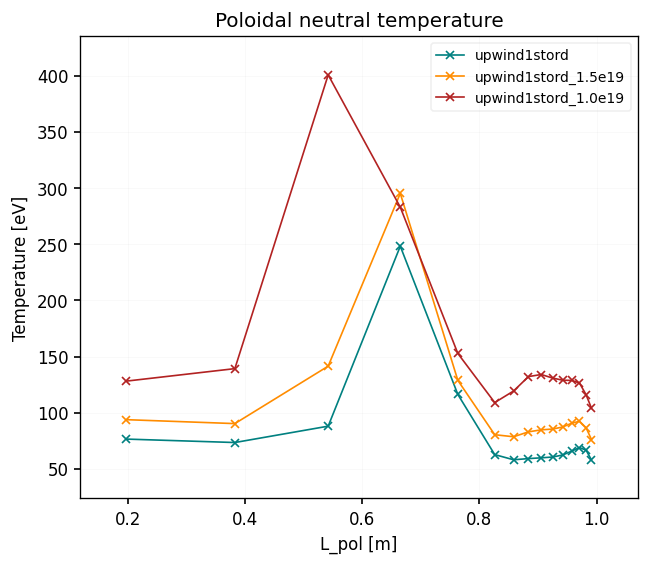

In [15]:

# colors = mpl.cm.get_cmap("plasma", len(cases))(range(len(cases)))
fig, ax = plt.subplots(dpi = 120)

cases = cs.keys()

# colors = ["teal", "darkorange", "firebrick"]

for i, case in enumerate(cases):
    ds = cs[case].ds.isel(t=-1)
    m = ds.metadata
    fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
    dist = np.cumsum(fl["dl"])
    
    if any([x in case for x in ["form2", "form4"]]):
        marker = "x"
    elif any([x in case for x in ["form1", "form3"]]):
        marker = "+"
    else:
        marker = "x"
    ax.plot(dist, fl["Td"], label = case, marker = marker, ms = 5, lw = 1, 
            # color = colors[i]
            )
    # ax.plot(dist, fl["Td+"],  marker = "o", ms = 5, lw = 0.5, c = colors[i])
# ax.set_yscale("symlog", linthresh = 1e-3)
ax.set_xlabel("L_pol [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_title("Poloidal neutral temperature")
ax.legend(fontsize="small")
# ax.set_ylim(0,200)

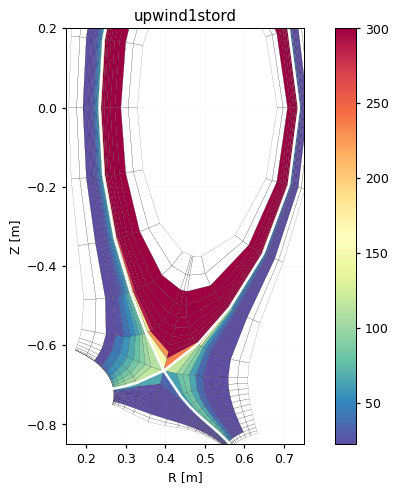

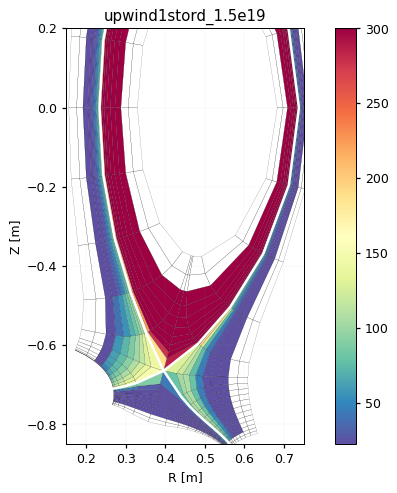

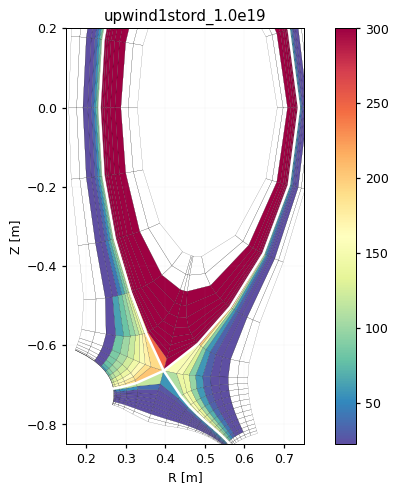

In [16]:


for name in cs:
    
	fig, ax = plt.subplots(figsize = (9,6), dpi = 90)
	ds = cs[name].ds.isel(t=-1)
	ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 25, vmin = 300, antialias = True, linewidth = 0.1, logscale = False)
	ax.set_ylim(-0.85, 0.2)
	ax.set_xlim(0.15,0.75)
	ax.set_title(name)


## Compare to base

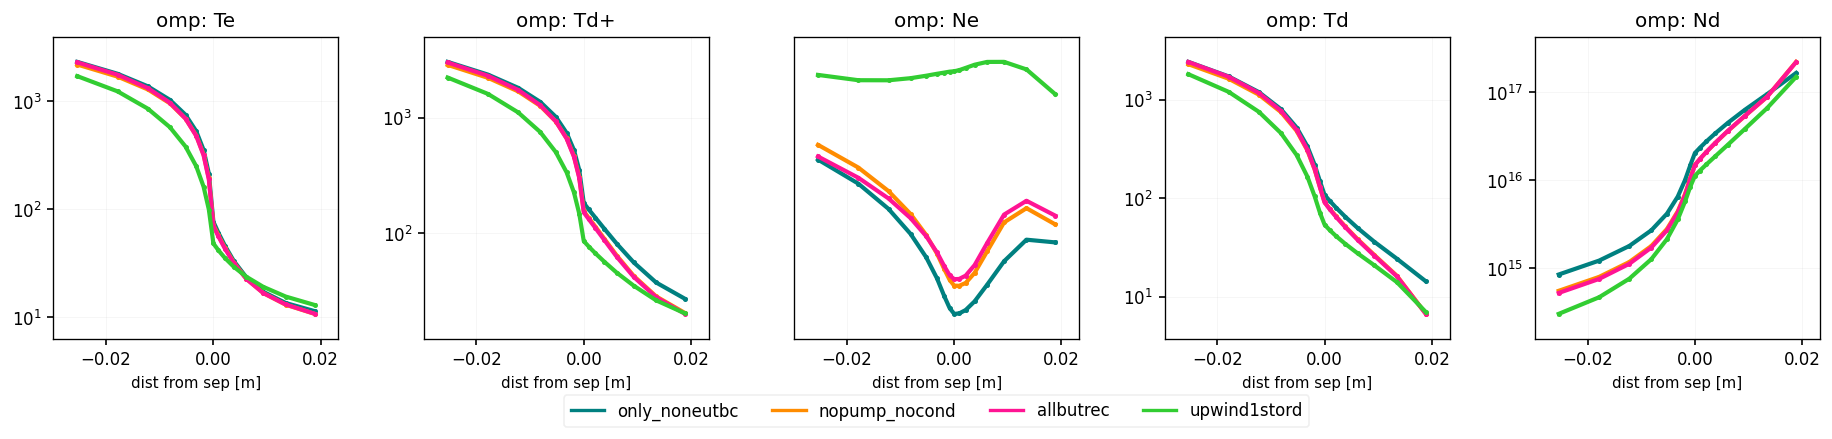

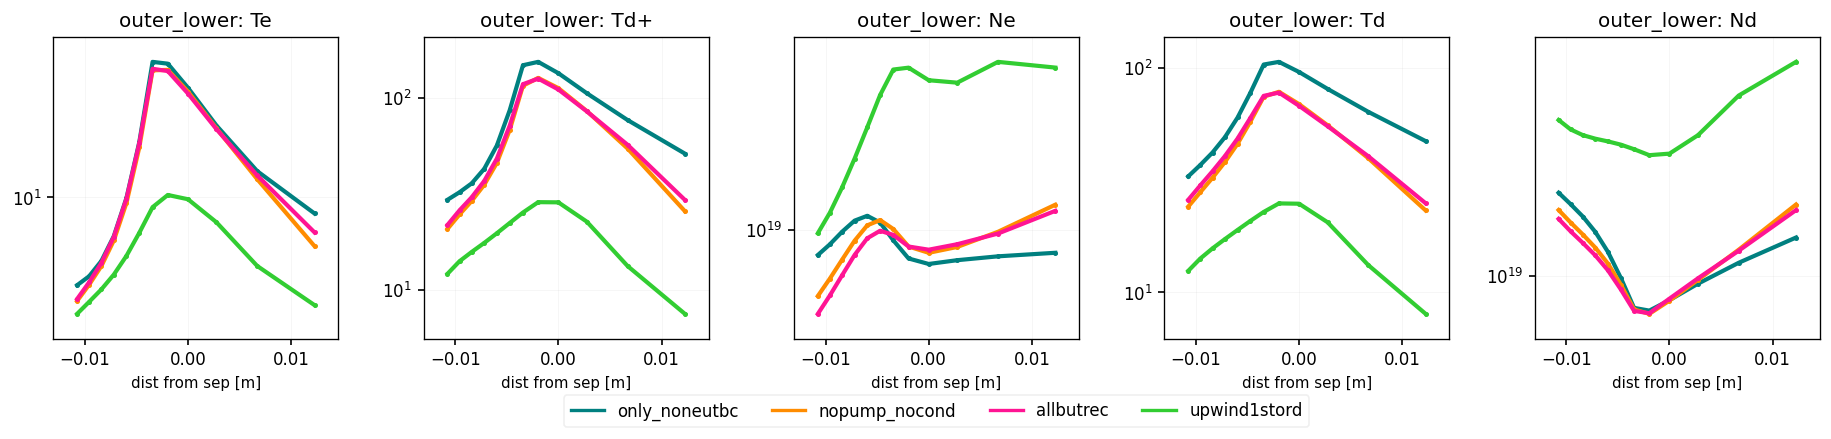

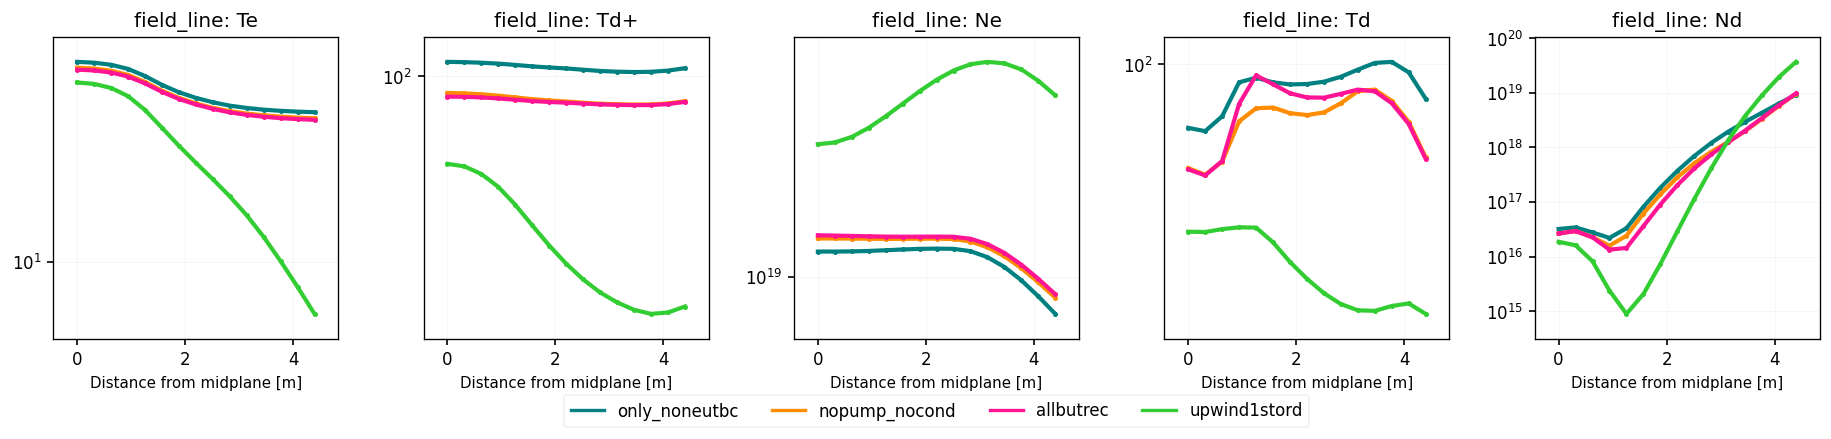

In [ ]:
toplot = {}
for case in cs:
    toplot[case] = cs[case].ds.isel(t=-1, x = slice(2,-2))
    
lineplot(
    toplot,
    clean_guards = False,
    logscale = True,
    params = ["Te", "Td+", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

# COnvergence

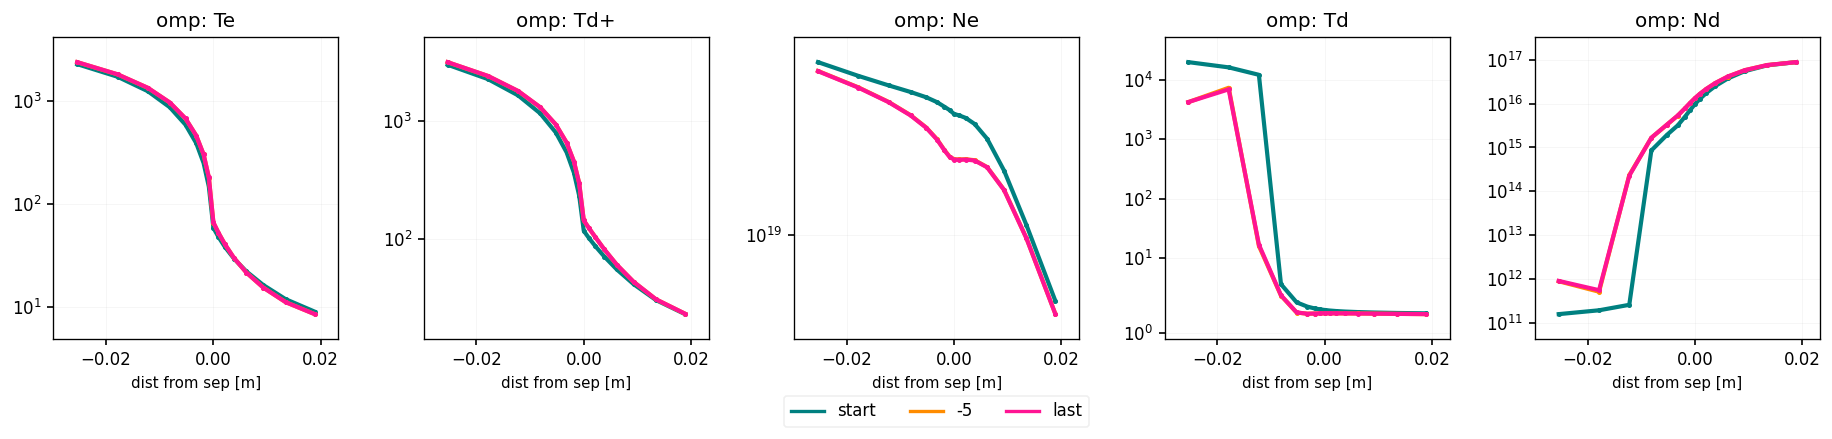

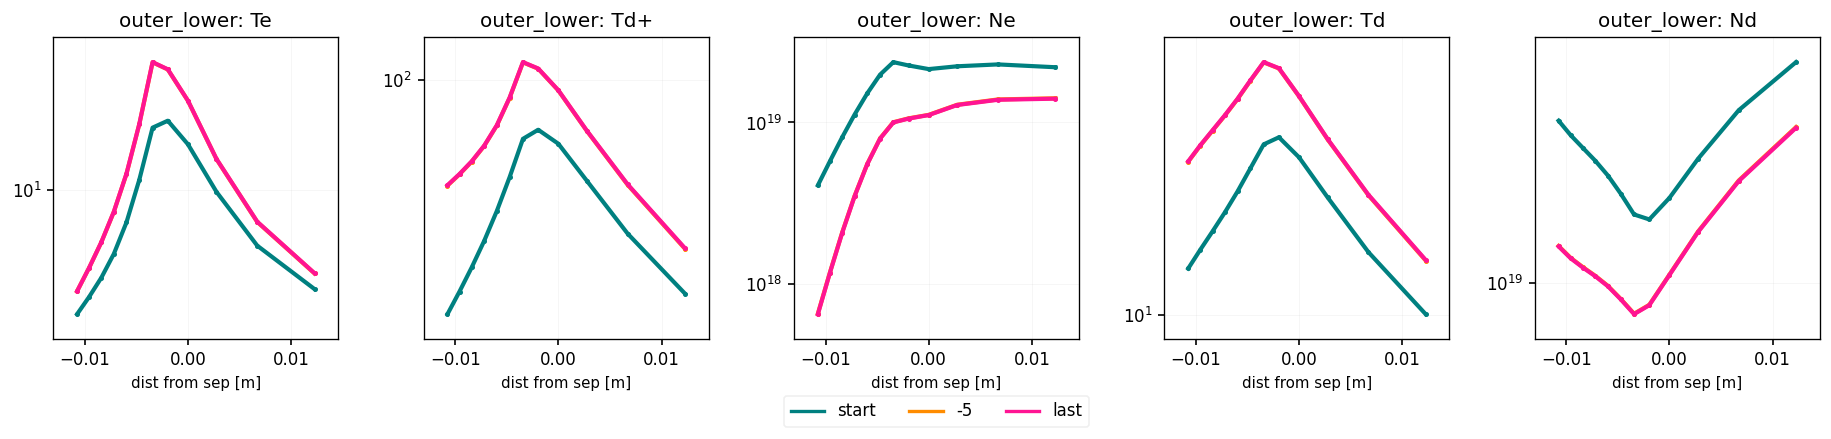

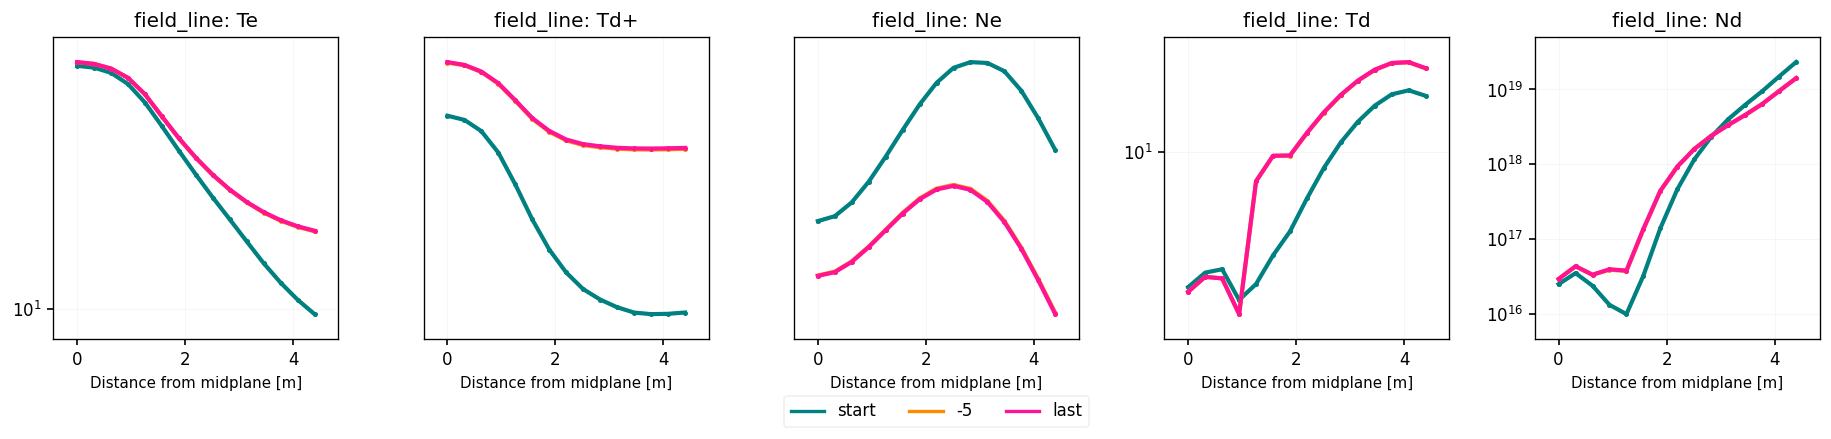

In [4]:
case = "nocxrec"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Ne", "Td", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

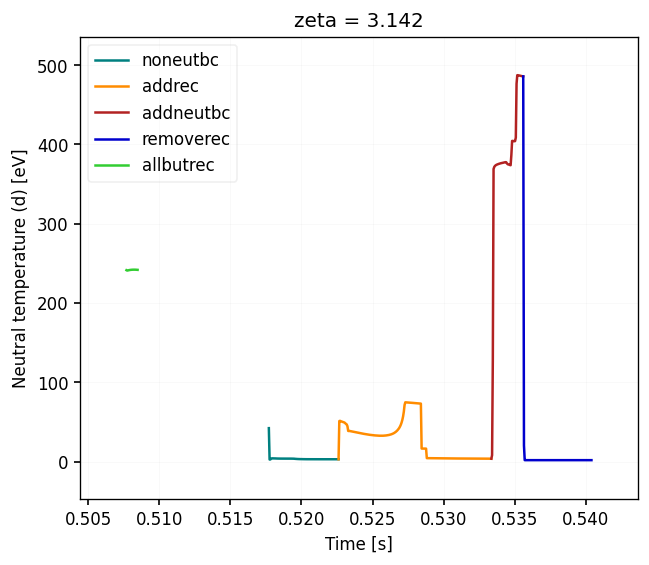

In [ ]:
for model in cs:
	case = cs[model]
	case.ds["Td"].hermesm.clean_guards().mean(["x", "theta"]).plot(label = model)
 
plt.legend()

In [28]:
y_omp

40

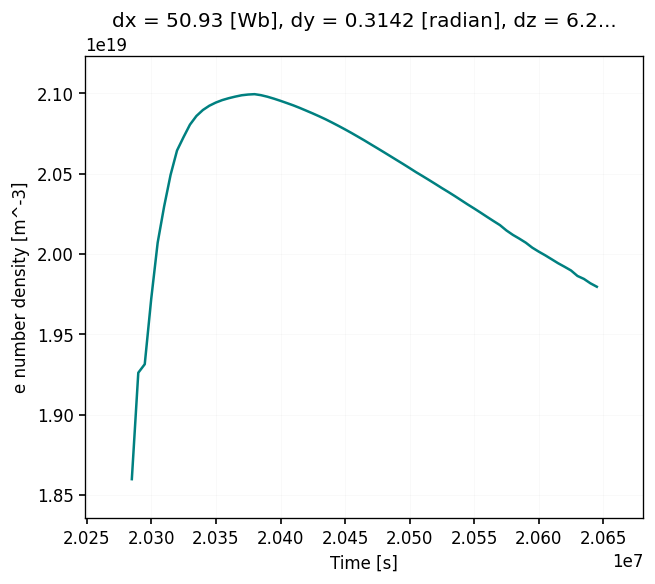

In [4]:
ds = cs["afn"].ds
m = ds.metadata

j2_2g = m["jyseps2_2"] + m["MYG"] * 3
j1_2g = m["jyseps1_2"] + m["MYG"] * 3
y_omp = int((j2_2g - j1_2g) / 2) + j1_2g
x_sep = m["ixseps1"]

x_sep

ds["Ne"].isel(x = x_sep, theta = y_omp).plot()

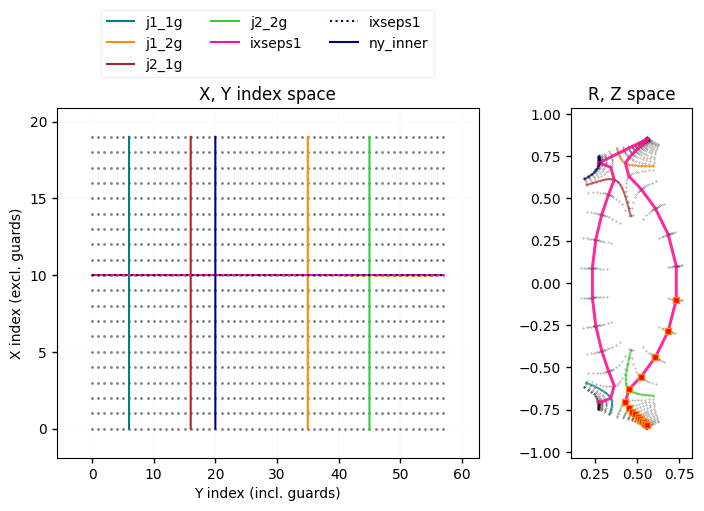

In [15]:
ds = cs["test"].ds.isel(t=-1)
m = ds.metadata

fl = ds.isel(x = m["ixseps1"], theta = slice(41,-2))
plot_selection(ds, fl)

(0.15, 0.75)

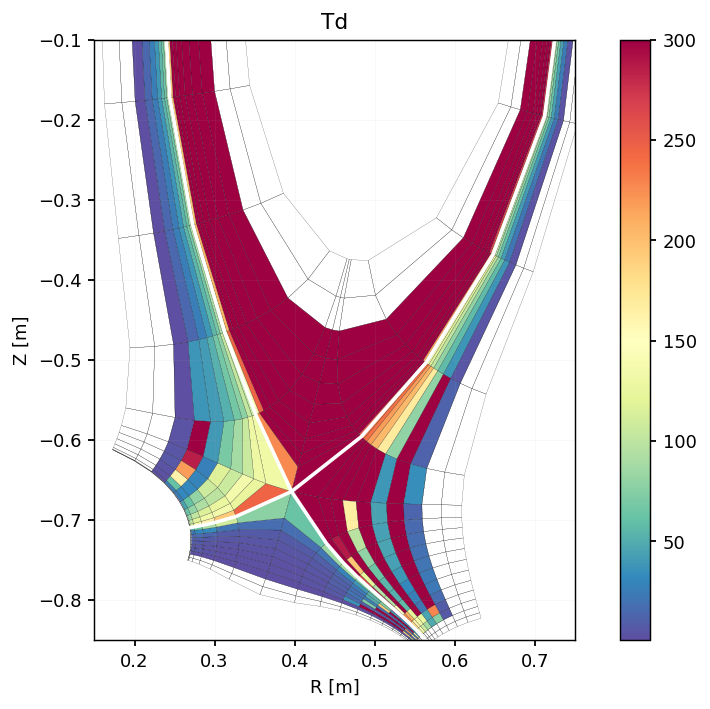

In [9]:

fig, ax = plt.subplots(figsize = (9,6), dpi = 130)
ds = cs["base_nocond"].ds.isel(t=-1)
(ds["Td"]).hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 300, vmin = None, antialias = True, linewidth = 0.1, logscale = False)
ax.set_ylim(-0.85, -0.1)
ax.set_xlim(0.15,0.75)


In [14]:
cs.keys()

dict_keys(['neumanncore'])

In [22]:
cs.keys()

dict_keys(['noneutbc'])

(0.15, 0.75)

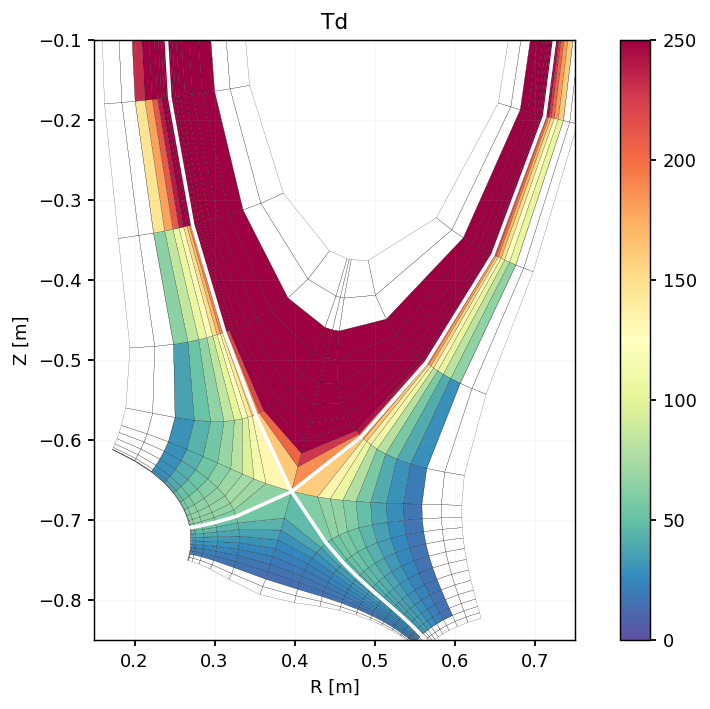

In [5]:

fig, ax = plt.subplots(figsize = (9,6), dpi = 130)
ds = cs["test"].ds.isel(t=-1)
ds["Td"].hermesm.clean_guards().bout.polygon(ax, cmap = "Spectral_r", vmax = 250, vmin = 0, antialias = True, linewidth = 0.1)
ax.set_ylim(-0.85, -0.1)
ax.set_xlim(0.15,0.75)
